# 4. Repeating Testing with Best Model Weights
### Calum Macdonald
A test run over the complete testing set was repeated with the model weights loaded from the previous best training run.

In [1]:
import os,sys

currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from utils import plot_utils
import time
import math
import random
import pdb
import matplotlib.pyplot as plt

# Import the utils for plotting the metrics
from plot_utils import notebook_utils_2
from repeating_classifier_training_utils import *

from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [2]:
# Dictionary mapping the ordinal labels to particle types 
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}
label_0 = "e"
label_1 = "mu"
# Fix the colour scheme for each particle type
COLOR_DICT = {"gamma":"red", "e":"blue", "mu":"green"}

npz_path = os.path.join(os.getcwd(), 'Index_Storage')

## Load test output

In [3]:
fprs = []
tprs = []
thresholds = []

run_id = "20200519_152505_test_with_tias_model"

dump_dir = "/home/cmacdonald/CNN/dumps"
dump_file = "test_validation_iteration_dump.npz"

softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}
    
test_dump_path = os.path.join(dump_dir,run_id,dump_file)
test_dump_np = np.load(test_dump_path, allow_pickle=True)

res_predictedlabels = np.concatenate(list([batch_array for batch_array in test_dump_np['predicted_labels']]))
res_softmaxes  = np.concatenate(list([batch_array for batch_array in test_dump_np['softmax']]))
res_labels   = np.concatenate(list([batch_array for batch_array in test_dump_np['labels']]))
res_energies = np.concatenate(list([batch_array for batch_array in test_dump_np['energies']]))
res_rootfiles = np.concatenate(list([batch_array for batch_array in test_dump_np['rootfiles']]))
res_eventids = np.concatenate(list([batch_array for batch_array in test_dump_np['eventids']]))
#res_positions = test_dump_np['positions'].reshape(-1)
res_angles = np.concatenate(list([batch_array for batch_array in test_dump_np['angles']]))

## Clean FiTQun Failed/Flagged Events

In [4]:
failed_idxs = np.load(os.path.join(npz_path, 'fq_failed_idxs.npz'),allow_pickle=True)['failed_indices_pointing_to_h5_test_set'].astype(int)
flagged_idxs = np.load(os.path.join(npz_path, 'fq_flagged_idxs.npz'),allow_pickle=True)['arr_0'].astype(int)

In [5]:
sres_predictedlabels = np.delete(res_predictedlabels,failed_idxs)
sres_softmaxes  = np.delete(res_softmaxes,failed_idxs,0)
sres_labels  = np.delete(res_labels,failed_idxs)
sres_energies = np.delete(res_energies,failed_idxs)
sres_rootfiles = np.delete(res_rootfiles,failed_idxs)
sres_eventids = np.delete(res_eventids,failed_idxs)
sres_angles = np.delete(res_angles,failed_idxs,0)

In [6]:
filtered_res_predictedlabels = np.delete(sres_predictedlabels,flagged_idxs)
filtered_res_softmaxes  = np.delete(sres_softmaxes,flagged_idxs,0)
filtered_res_labels  = np.delete(sres_labels,flagged_idxs)
filtered_res_energies = np.delete(sres_energies,flagged_idxs)
filtered_res_rootfiles = np.delete(sres_rootfiles,flagged_idxs)
filtered_res_eventids = np.delete(sres_eventids,flagged_idxs)
filtered_res_angles = np.delete(sres_angles,flagged_idxs,0)

## Plot Confusion Matrices

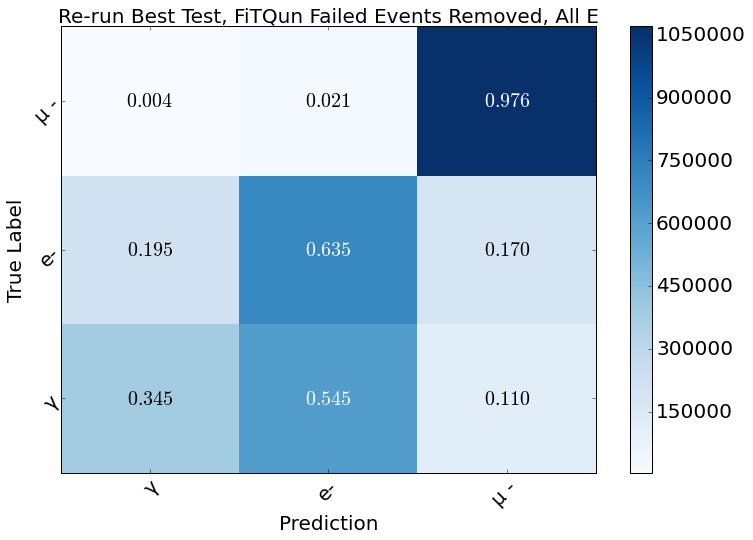

In [7]:
plot_confusion_matrix(sres_labels,sres_predictedlabels,
                      ['\u03B3','e-','\u03BC -'],title='Re-run Best Test, FiTQun Failed Events Removed, All E')

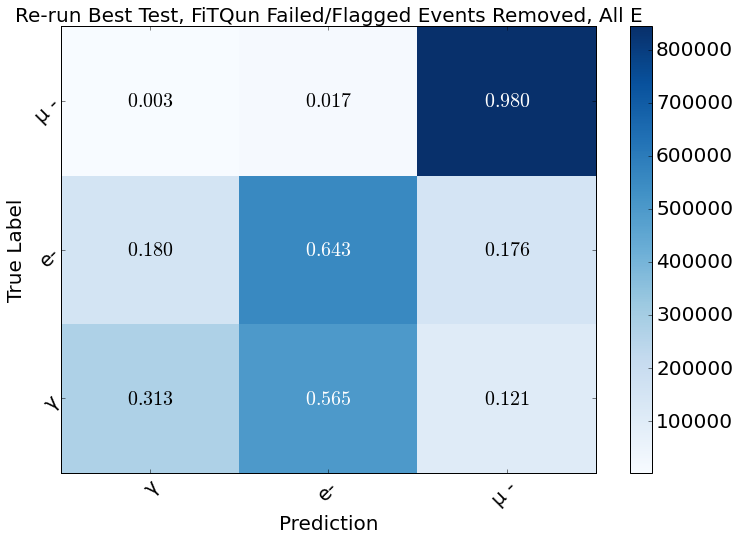

In [8]:
plot_confusion_matrix(filtered_res_labels,filtered_res_predictedlabels,
                      ['\u03B3','e-','\u03BC -'],title='Re-run Best Test, FiTQun Failed/Flagged Events Removed, All E')

Find Critical Points: 100% [000000000000000000000000000000000000] Time: 0:00:07


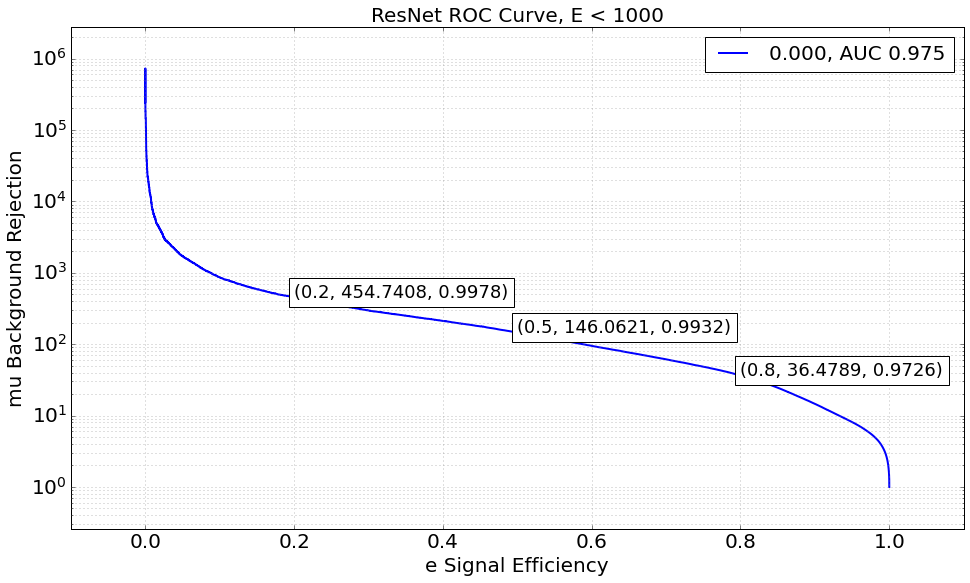

In [24]:
res_fpr, res_tpr, res_threshold = prep_roc_data(filtered_res_softmaxes,filtered_res_labels,'rejection',
                                                softmax_index_dict,
                                                label_0,label_1,energies=np.squeeze(filtered_res_energies),
                                                threshold=1000
                                                )
fprs = [res_fpr]
tprs = [res_tpr]
thresholds = [res_threshold]
# fprs.append(low_e_res_fpr)
# tprs.append(low_e_res_tpr)
# thresholds.append(low_e_res_threshold)
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds), 'rejection',["e", "mu"],title='ResNet ROC Curve, E < 1000')